## Import libraries

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from decimal import Decimal
import numpy as np
import glob
import importlib
import gc
import matplotlib.pyplot as plt
#from livelossplot import PlotLossesKeras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import gc # Garbage Collector
import pandas as pd
from numpy import savez_compressed
from joblib import dump, load
from sklearn.model_selection import train_test_split

from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import LSTM, TimeDistributed, BatchNormalization
from keras.layers.core import Dense, Flatten, Dropout, RepeatVector, Reshape, Dropout
from keras.layers.convolutional import Conv3D, Conv3DTranspose, MaxPooling3D 
from keras.callbacks import ModelCheckpoint, EarlyStopping

#leakyrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

def plot_loss(history):
  plt.figure(figsize=(16,8))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 0.4])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
    
from platform import python_version
import keras
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # True dynamically grow the memory used on the GPU
sess = tf.compat.v1.Session(config=config)
set_session(sess)

from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print('Notebook running on Python', python_version())
print('Numpy version', np.version.version)
print('Pandas version', pd.__version__)
print('Keras version ', keras.__version__,'and TensorFlow', tf.__version__, '(CUDA:', tf.test.is_built_with_cuda(), '- GPUs available:', get_available_gpus(), ')')

Using TensorFlow backend.


Notebook running on Python 3.8.11
Numpy version 1.20.3
Pandas version 1.3.1
Keras version  2.3.1 and TensorFlow 2.2.0 (CUDA: True - GPUs available: [] )


## Load data from files

In [2]:
datasetRURpath = "dc21-rur-and-gpu-data/RUR/"
datasetGPUpath = "dc21-rur-and-gpu-data/GPU/"

### RUR

In [3]:
dfrur = pd.DataFrame()
files = glob.glob(datasetRURpath + "/20*.csv") 
for filename in files:
    data = pd.read_csv(filename)
    dfrur = dfrur.append(data, ignore_index=True)
dfrur['end_time'] = pd.to_datetime(dfrur['end_time'])
dfrur['start_time'] = pd.to_datetime(dfrur['start_time'])

### GPU

In [4]:
dfgpu = pd.read_csv(datasetGPUpath + "/gc_full.csv")
dfgpuclean = dfgpu.dropna(subset=['insert'], how='all', inplace=False)
print(dfgpu.columns)
print(len(dfgpu))
print(dfgpu.head())

Index(['SN', 'location', 'insert', 'remove', 'duration', 'out', 'event'], dtype='object')
37343
             SN     location               insert               remove  \
0  320117100060  c11-2c1s4n1  2017-04-09 21:36:19  2019-08-01 20:07:33   
1  320117100061   c9-3c1s2n1  2017-04-09 21:36:19  2019-08-01 20:07:33   
2  320117100063   c6-2c1s2n0  2017-04-09 21:36:19  2019-08-01 20:07:33   
3  320117100064  c10-2c1s5n1  2017-04-09 21:36:19  2019-08-01 20:07:33   
4  320117100065   c3-2c1s2n0  2017-04-09 21:36:19  2019-08-01 20:07:33   

     duration    out event  
0  72916274.0  False   NaN  
1  72916274.0  False   NaN  
2  72916274.0  False   NaN  
3  72916274.0  False   NaN  
4  72916274.0  False   NaN  


In [5]:
startts = pd.to_datetime(dfgpu.sort_values('insert').head(1)['insert'].tolist()[0]).strftime("%s")
endts = pd.to_datetime(dfgpu.sort_values('remove').tail(1)['remove'].tolist()[0]).strftime("%s")
print("Start:", startts)
print("End:", endts)
print("Difference:", int(endts) - int(startts))

Start: 1384882515
End: 1564682853
Difference: 179800338


In [6]:
insert_list = dfgpuclean.sort_values('insert')[['SN', 'insert']]
insert_list = insert_list.values.tolist()
remove_list = dfgpu.sort_values('remove')[['SN', 'remove']]
remove_list = remove_list.values.tolist()

In [7]:
dictevents = {}
for event in insert_list:
    ts = event[1]
    if ts:
        ts = pd.to_datetime(ts).strftime("%s")
        key = dictevents.get(ts)
        if not key:
            dictevents[ts] = 1
        else:
            dictevents[ts] += 1
            
for event in remove_list:
    ts = event[1]
    if ts:
        ts = pd.to_datetime(ts).strftime("%s")
        key = dictevents.get(ts)
        if not key:
            dictevents[ts] = -1
        else:
            dictevents[ts] -= 1

In [8]:
%%time 
list_gpus = [0]
list_ts = []
cnt = 0
for idx, ts in enumerate(range(int(startts), int(endts))):
    value = 0
    if str(ts) in dictevents:
        value = dictevents[str(ts)]
    prev = list_gpus[idx]
    total = prev + value
    list_gpus.append(total)
    list_ts.append(ts)
    #if idx == 100:
    #    break

CPU times: user 1min 31s, sys: 5.03 s, total: 1min 36s
Wall time: 1min 36s


In [9]:
%%time
df = pd.DataFrame(list_ts)
df['gpus'] = list_gpus[1:]
df['time'] = pd.to_datetime(df[0], unit='s')
df = df[['time', 'gpus']]

CPU times: user 1min 19s, sys: 28.8 s, total: 1min 48s
Wall time: 1min 51s


In [10]:
##GPUs available
df.index = pd.to_datetime(df['time'],format='%m/%d/%y %I:%M%p')
dfgr = df.groupby(pd.Grouper(freq='m'))['gpus']
gpusavail = dfgr.max()[16:-1]

df.index = pd.to_datetime(df['time'],format='%m/%d/%y %I:%M%p')
dfgr = df.groupby(pd.Grouper(freq='m'))['gpus']
gpusmean = dfgr.mean()[16:-1]

df.index = pd.to_datetime(df['time'],format='%m/%d/%y %I:%M%p')
dfgr = df.groupby(pd.Grouper(freq='m'))['gpus']
gpussum = dfgr.sum()[16:-1]

In [11]:
##Jobs with errors
dfrur.index = pd.to_datetime(dfrur['start_time'],format='%m/%d/%y %I:%M%p')
dfalps=dfrur.groupby(pd.Grouper(freq='m'))['alps_exit'].apply(lambda x: (x!=0).sum())

In [12]:
#Other metrics
dfaux = dfrur[['start_time', 'node_count', 'max_rss', 'stime', 'utime', 'gpu_maxmem', 'gpu_secs']]
dfaux.index = pd.to_datetime(dfaux['start_time'],format='%m/%d/%y %I:%M%p')
aux = dfaux.groupby(pd.Grouper(freq='m'))
datasetsum = aux.sum()
datasetsum = datasetsum.rename(columns={"node_count": "sum node_count", "max_rss": "sum max_rss", 
                                  "stime": "sum stime", "utime": "sum utime", "gpu_maxmem": "sum gpu_maxmem",
                                  "gpu_secs": "sum gpu_secs"})
datasetmean = aux.mean()
datasetmean = datasetmean.rename(columns={"node_count": "mean node_count", "max_rss": "mean max_rss", 
                                  "stime": "mean stime", "utime": "mean utime", "gpu_maxmem": "mean gpu_maxmem",
                                  "gpu_secs": "mean gpu_secs"})
datasetmax = aux.max()
datasetmax = datasetmax.rename(columns={"node_count": "max node_count", "max_rss": "max max_rss", 
                                  "stime": "max stime", "utime": "max utime",
                                  "gpu_maxmem": "max gpu_maxmem", "gpu_secs": "max gpu_secs"})
datasetstd = aux.std()
datasetstd = datasetstd.rename(columns={"node_count": "std node_count", "max_rss": "std max_rss", 
                                  "stime": "std stime", "utime": "std utime",
                                  "gpu_maxmem": "std gpu_maxmem", "gpu_secs": "std gpu_secs"})
totaljobs = aux['start_time'].count()

In [27]:
frames = [gpusavail, datasetmax[datasetmax.columns[1:3]]]
dataset = pd.concat(frames, axis=1)
dataset = dataset.rename(columns={"gpus": "#GPUs Available", "start_time": "#JobsRunning", 
                                  "alps_exit": "#JobsFailed", "node_count": "#NodesAlloc",
                                  "max_rss": "Mean Max Host Memory", "stime": "Mean System Time",
                                  "utime": "Mean User Time", "gpu_maxmem": "Mean GPU Max Memory",
                                  "gpu_secs": "Sum GPU Time",
                                  "max max_rss": "Maximum Host Memory (GB)",
                                  "max node_count": "#Nodes Available"
                                 })

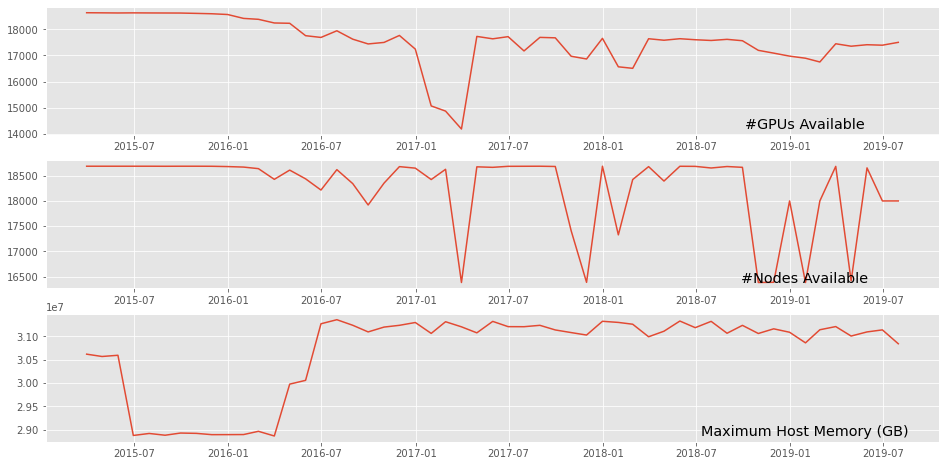

In [28]:
plt.style.use("ggplot")
plt.figure(figsize=(16,8))
for i in range(0, len(dataset.columns)):
    plt.subplot(len(dataset.columns), 1, i+1)
    name = dataset.columns[i]
    plt.plot(dataset[name])
    plt.title(name, x=0.85, y=0)
plt.show()

In [29]:
frames = [gpusavail, totaljobs, dfalps, datasetmax[datasetmax.columns[1]],datasetmean[datasetmean.columns[1:5]],
         datasetsum[datasetsum.columns[-1]]]
dataset = pd.concat(frames, axis=1)
dataset = dataset.rename(columns={"gpus": "#GPUsAvail", "start_time": "#JobsRunning", 
                                  "alps_exit": "#JobsFailed", "node_count": "#NodesAlloc",
                                  "max_rss": "Mean Max Host Memory", "stime": "Mean System Time",
                                  "utime": "Mean User Time", "gpu_maxmem": "Mean GPU Max Memory",
                                  "gpu_secs": "Sum GPU Time"
                                 })

In [30]:
frames = [gpusavail, totaljobs, dfalps, dataset[dataset.columns[1]], dataset[dataset.columns[2]], datasetmax[datasetmax.columns[1:]],datasetsum[datasetsum.columns[:]],datasetmean[datasetmean.columns[:]]]#,datasetstd[datasetstd.columns[:]]]
dfAux = pd.concat(frames, axis=1)
dfAux.columns

Index(['gpus', 'start_time', 'alps_exit', '#JobsRunning', '#JobsFailed',
       'max node_count', 'max max_rss', 'max stime', 'max utime',
       'max gpu_maxmem', 'max gpu_secs', 'sum node_count', 'sum max_rss',
       'sum stime', 'sum utime', 'sum gpu_maxmem', 'sum gpu_secs',
       'mean node_count', 'mean max_rss', 'mean stime', 'mean utime',
       'mean gpu_maxmem', 'mean gpu_secs'],
      dtype='object')

<ipython-input-32-4fac5ade34be>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  aux = dfAux.drop("start_time", 1)
<ipython-input-32-4fac5ade34be>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  aux = aux.drop("alps_exit", 1)


Correlation data of jobs with the following metrics:
	Numerical-Numerical: Person's R [-1, 1]
	Nominal-Numerical (and VV): Correlation ratio [0,1] 


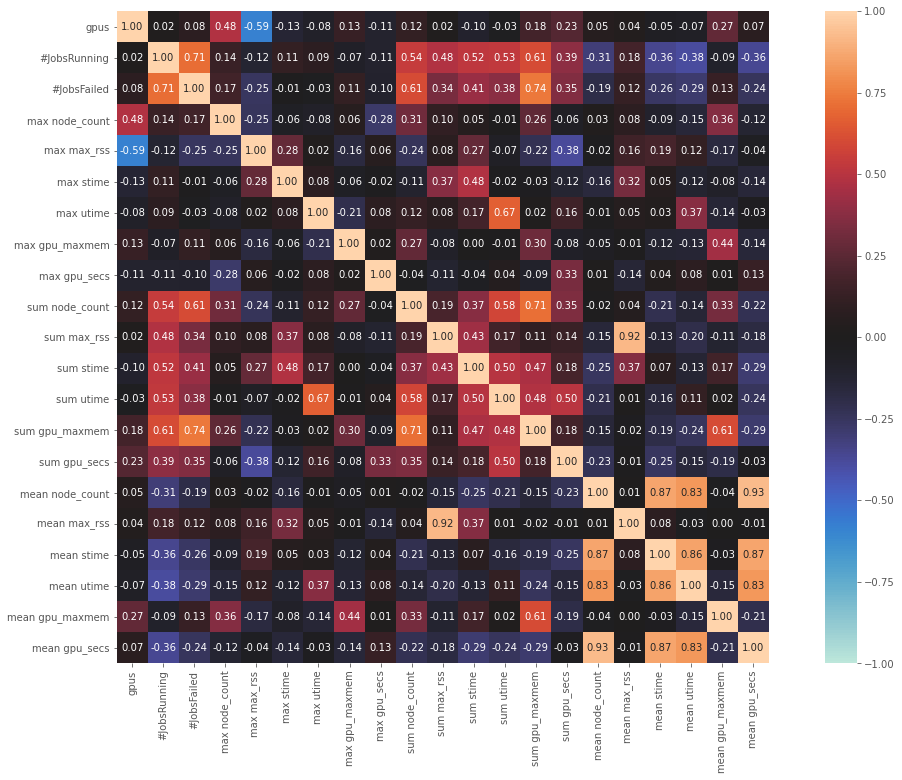

{'corr':                      gpus  #JobsRunning  #JobsFailed  max node_count  \
 gpus             1.000000      0.021164     0.081733        0.479710   
 #JobsRunning     0.021164      1.000000     0.706870        0.137113   
 #JobsFailed      0.081733      0.706870     1.000000        0.168491   
 max node_count   0.479710      0.137113     0.168491        1.000000   
 max max_rss     -0.585858     -0.123681    -0.251369       -0.249603   
 max stime       -0.127255      0.114265    -0.008835       -0.057967   
 max utime       -0.082115      0.085427    -0.031403       -0.083341   
 max gpu_maxmem   0.126755     -0.071863     0.109758        0.058842   
 max gpu_secs    -0.105308     -0.109094    -0.097384       -0.280917   
 sum node_count   0.116345      0.544303     0.605171        0.309940   
 sum max_rss      0.020892      0.480431     0.335872        0.104272   
 sum stime       -0.095591      0.517851     0.414602        0.053837   
 sum utime       -0.032940      0.528621   

In [32]:
from dython.nominal import associations

aux = dfAux.drop("start_time", 1)
aux = aux.drop("alps_exit", 1)

print('Correlation data of jobs with the following metrics:')
print('\tNumerical-Numerical: Person\'s R [-1, 1]')
print('\tNominal-Numerical (and VV): Correlation ratio [0,1] ')
associations(aux, nominal_columns=[], figsize=(20,12))